In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms

# Dataset 2: https://www.kaggle.com/code/faressayah/chest-x-ray-medical-diagnosis-with-cnn-densenet/input

# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Load train data 
train_data = datasets.ImageFolder(root='data/chest_xray/chest_xray/train', transform=transform)
test_data = datasets.ImageFolder(root='data/chest_xray/chest_xray/test', transform=transform)
val_data = datasets.ImageFolder(root='data/chest_xray/chest_xray/val', transform=transform)

In [3]:
batch_size = 10
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=4)  
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=4)

torch.Size([10, 1, 256, 256])


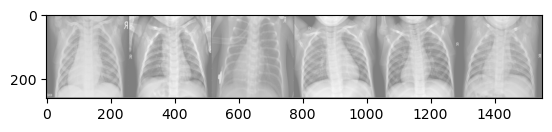

labels: tensor([1, 0, 1, 0, 0, 0])


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
it = iter(train_loader)
x, y = next(it)

print(x.shape)

# show images
imshow(torchvision.utils.make_grid(x[:6]))
print('labels:', y[:6])

In [5]:
import torch_directml
# select the GPU device if available
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch_directml.is_available():
    device = torch_directml.device(torch_directml.default_device())
else:
    device = torch.device("cpu")

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

count_batches = 0

class Fire(nn.Module):
    def __init__(self, inplanes: int, squeeze_planes: int, expand1x1_planes: int, expand3x3_planes: int) -> None:
        super().__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes, kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat(
            [self.expand1x1_activation(self.expand1x1(x)), self.expand3x3_activation(self.expand3x3(x))], 1
        )

class ConvNet(nn.Module):    
    def __init__(self, num_classes):
        super().__init__()
        self.pipeline = nn.Sequential(
            # 256x256
            nn.Conv2d(1, 64, kernel_size=3, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 128x128
            nn.Conv2d(64, 48, kernel_size=3, stride=2),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
            # 64x64
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
            # 32x32
            nn.Conv2d(48, 32, kernel_size=3, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # 16x16
            nn.Conv2d(32, 16, kernel_size=3, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            # 8x8
            nn.Conv2d(16, num_classes, kernel_size=1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(7*7, num_classes),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
        
    def forward(self, x):
        x = self.pipeline(x)
        x = self.classifier(x.flatten(1))
        x = F.sigmoid(x)
        return x

In [6]:
import torch.optim as optim

num_classes = 1
model = ConvNet(num_classes)
model.to(device)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_params = sum(p.numel() for p in model.parameters())
num_params

47203

In [7]:
train_losses = []
epochs = []

In [8]:
from utils import RunningAverage
PATH = './mnist_medical.pth'

num_epochs = 50

model.train()
for ep in range(num_epochs):
    loss_avg = RunningAverage()
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(images)
        outputs = outputs.squeeze(1)
        loss = loss_fn(outputs, labels.float())

        # backward & optimize
        loss.backward()
        optimizer.step()

        # print statistics
        loss_avg.update(loss.item())
        if (i+1) % 100 == 0:
            print(f'[{ep + 1}, {i + 1:5d}] loss: {loss_avg():05.3f}')
            running_loss = 0.0
    train_losses.append(loss.item())
    epochs.append(ep)
    torch.save(model.state_dict(), PATH)

print('Finished Training')

/home/hgoz/anaconda3/envs/06-image/lib/python3.10/site-packages/torch/nn/functional.py:3098: UserWarning: The operator 'aten::binary_cross_entropy' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /home/vsts/work/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  return torch._C._nn.binary_cross_entropy(input, target, weight, reduction_enum)


[1,   100] loss: 0.232
[1,   200] loss: 0.217
[1,   300] loss: 0.208
[1,   400] loss: 0.203
[1,   500] loss: 0.194
[2,   100] loss: 0.149
[2,   200] loss: 0.158
[2,   300] loss: 0.160
[2,   400] loss: 0.151
[2,   500] loss: 0.148
[3,   100] loss: 0.148
[3,   200] loss: 0.145
[3,   300] loss: 0.135
[3,   400] loss: 0.132
[3,   500] loss: 0.126
[4,   100] loss: 0.114
[4,   200] loss: 0.109
[4,   300] loss: 0.111
[4,   400] loss: 0.116
[4,   500] loss: 0.114
[5,   100] loss: 0.137
[5,   200] loss: 0.107
[5,   300] loss: 0.111
[5,   400] loss: 0.110
[5,   500] loss: 0.108
[6,   100] loss: 0.116
[6,   200] loss: 0.101
[6,   300] loss: 0.097
[6,   400] loss: 0.096
[6,   500] loss: 0.098
[7,   100] loss: 0.061
[7,   200] loss: 0.078
[7,   300] loss: 0.080
[7,   400] loss: 0.087
[7,   500] loss: 0.089
[8,   100] loss: 0.095
[8,   200] loss: 0.093
[8,   300] loss: 0.092
[8,   400] loss: 0.090
[8,   500] loss: 0.089
[9,   100] loss: 0.059
[9,   200] loss: 0.072
[9,   300] loss: 0.071
[9,   400] 

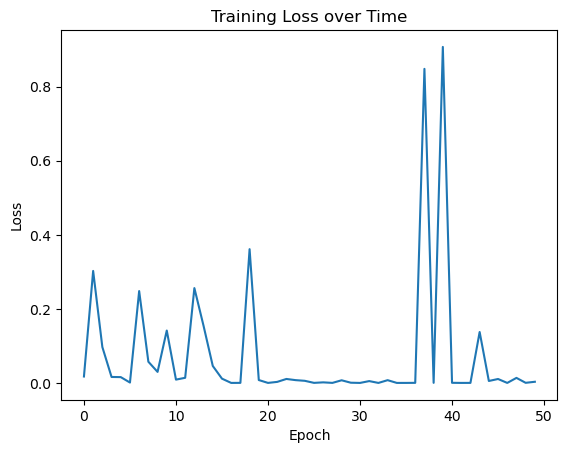

0.003108934499323368


In [12]:
plt.plot(np.arange(len(epochs)), train_losses)
plt.title('Training Loss over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
print(train_losses[-1])

In [9]:
PATH = './mnist_medical.pth'
model = ConvNet(1)
model.load_state_dict(torch.load(PATH))
model.eval()
with torch.no_grad():
    precisions = []
    recalls = []
    n_correct = 0
    n_samples = 0
    for x, y in test_loader:
        outputs = model(x).squeeze(1)
        predictions = (outputs > 0.5).float()
        n_samples += x.shape[0]
        n_correct += (predictions == y).sum().item()        
    acc = n_correct / n_samples
    print(f'Accuracy = {100*acc:.2f}')

Accuracy = 74.68


In [29]:
from torchmetrics.classification import BinaryConfusionMatrix

confusion_mtx = BinaryConfusionMatrix()

outputs = []

with torch.no_grad():
    for x, y in test_loader:
        output = model(x).squeeze(1)
        pred = output > 0.5
        confusion_mtx.update(pred, y)
        outputs.extend(output)

conf_mat = confusion_mtx.compute()

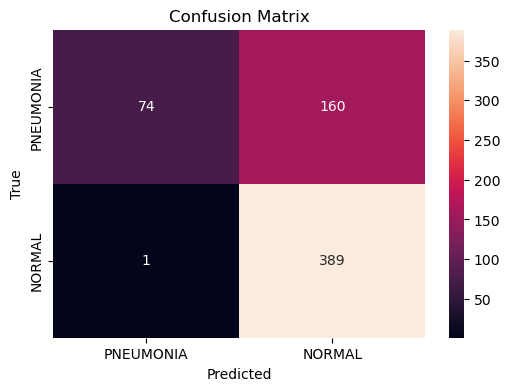

In [30]:
import seaborn as sn

figure = plt.figure(figsize=(6,4))
sn.heatmap(conf_mat, annot=True, fmt='d', xticklabels=['PNEUMONIA', 'NORMAL'], yticklabels=['PNEUMONIA', 'NORMAL'])

plt.xlabel('Predicted')
plt.ylabel('True') 
plt.title('Confusion Matrix')

plt.show()

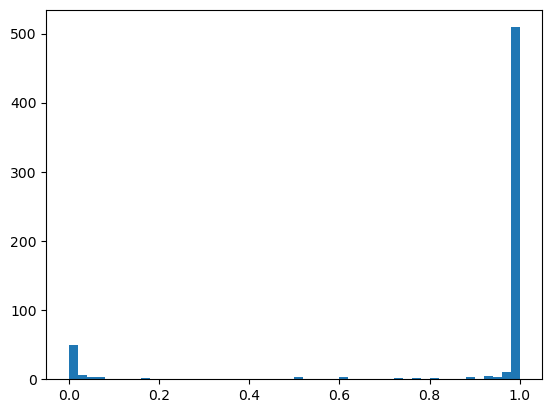

In [34]:
plt.hist(outputs, 50);

# Using a pre-trained model

In [10]:
# from torchvision.models import vit_b_16

# model = vit_b_16(pretrained=True)

# for param in model.parameters():
#     param.requires_grad = False

# model.classifier = nn.Linear(model.classifier.in_features, num_classes)

# for param in model.classifier.parameters():
#     param.requires_grad = True

# loss_fn = nn.BCEWithLogitsLoss()
